# Notebook for cross validation of decision boundry on logistic regressor in AI jobs
***
## Imports and Initializations

In [157]:
#Imports
import cv2
import h5py
import joblib
import jobsConfig as config
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import floor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix

#Initializations
train = h5py.File(config.TRAIN_FEATURES, "r")
features = train["features"]
labels = train["labels"]
val = h5py.File(config.VAL_FEATURES, "r")
val_images = h5py.File(config.VAL_HDF5)
colorstorm = joblib.load(config.MODEL_PATH)

__Take a look at number of datapoints to get a handle on a good number of cross validations__

In [27]:
print("Total Datapoints: {}\n5 fold cv instances/class: {:.02f}\n3 fold cv instances/class: {:.02f}".format(len(labels), len(labels)/5, len(labels)/3))

Total Datapoints: 1663
5 fold cv instances/class: 332.60
3 fold cv instances/class: 554.33


***
## Proceeding with 5 fold cross validation
***Split data into 5 subsets***

In [28]:
def cross_val_split(X, y, cv):
    num_features = floor(1/cv*len(y))
    X_cv = []
    y_cv = []
    for i in range(cv-1):
        X, Xs, y, ys = train_test_split(X, y, test_size = num_features, stratify = y)
        X_cv.append(Xs)
        y_cv.append(ys)
        if i == cv-2:
            X_cv.append(X)
            y_cv.append(y)
            
    return X_cv, y_cv

In [29]:
X_cv, y_cv = cross_val_split(features[:], labels[:], 5)

__Now have 5 datasets which all contain about the same number of instances__
### Next loop through the datasets and perform cross validation

In [136]:
def cross_validate(X_cv, y_cv, predictor, thresh, metrics, metric_names):
    
    #List to hold scores from each cross validation
    scores = []
    
    for i, (X,y) in enumerate(zip(X_cv,y_cv)):
        
        #Split up data
        X_train = np.vstack([X_cv[j] for j in range(len(y_cv)) if j!=i])
        y_train = np.hstack([y_cv[j] for j in range(len(y_cv)) if j !=i])
        X_test = X_cv[i]
        y_test = y_cv[i]
        
        #Train model
        predictor.fit(X_train, y_train)
        predictions = (predictor.predict_proba(X_test) >= thresh).astype("int")[:,1]
        
        #Calculate scores and append to list
        scores.append([metric(y_test, predictions) for metric in metrics])
    
    #Return the scores for each cross validation as an array
    results = pd.DataFrame(np.array(scores), columns = metric_names)
    results["DecisonBoundry"] = [thresh]*len(y_cv)
    return results

### Try ranges of thresholds until satisfactory performance is achieved

In [137]:
def find_thresh(X_cv, y_cv, predictor, metrics, metric_names, threshes = np.arange(0.5, 0.61, .01)):
    
    #List to hold results
    results = []
    
    #Loop through all thresholds append each cross validation results to the master list of results
    for thresh in threshes:
        results.append(cross_validate(X_cv, y_cv, predictor, thresh, metrics, metric_names))
        
    #Return the final threshold and dataframe containing the results
    metric_names.append("DecisionBoundry")
    return pd.DataFrame(np.vstack(results), columns = metric_names)
        

In [135]:
thresh_search = find_thresh(X_cv, y_cv, colorstorm, [accuracy_score, recall_score, precision_score], ["accuracy", "recall", "precision"], threshes = np.arange(0.5, 1, .1))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\OCInstalls\Anaconda\envs\jobs\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\OCInstalls\Anaconda\envs\jobs\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (m

### Visualize

In [152]:
def visualize_cv(grid):
    plt.style.use("seaborn")
    grouped = grid.groupby("DecisionBoundry", as_index = False).mean()
    fig, ax = plt.subplots(figsize = (25,10))
    for col in grouped.columns[1:]:
        ax.plot(grouped["DecisionBoundry"], grouped[col], label = col)
    ax.set_xlabel("Decision Boundry")
    ax.set_ylabel("Metric Value")
    ax.set_title("Metric Values at Varying Decision Boundries")
    ax.legend()
    plt.tight_layout()

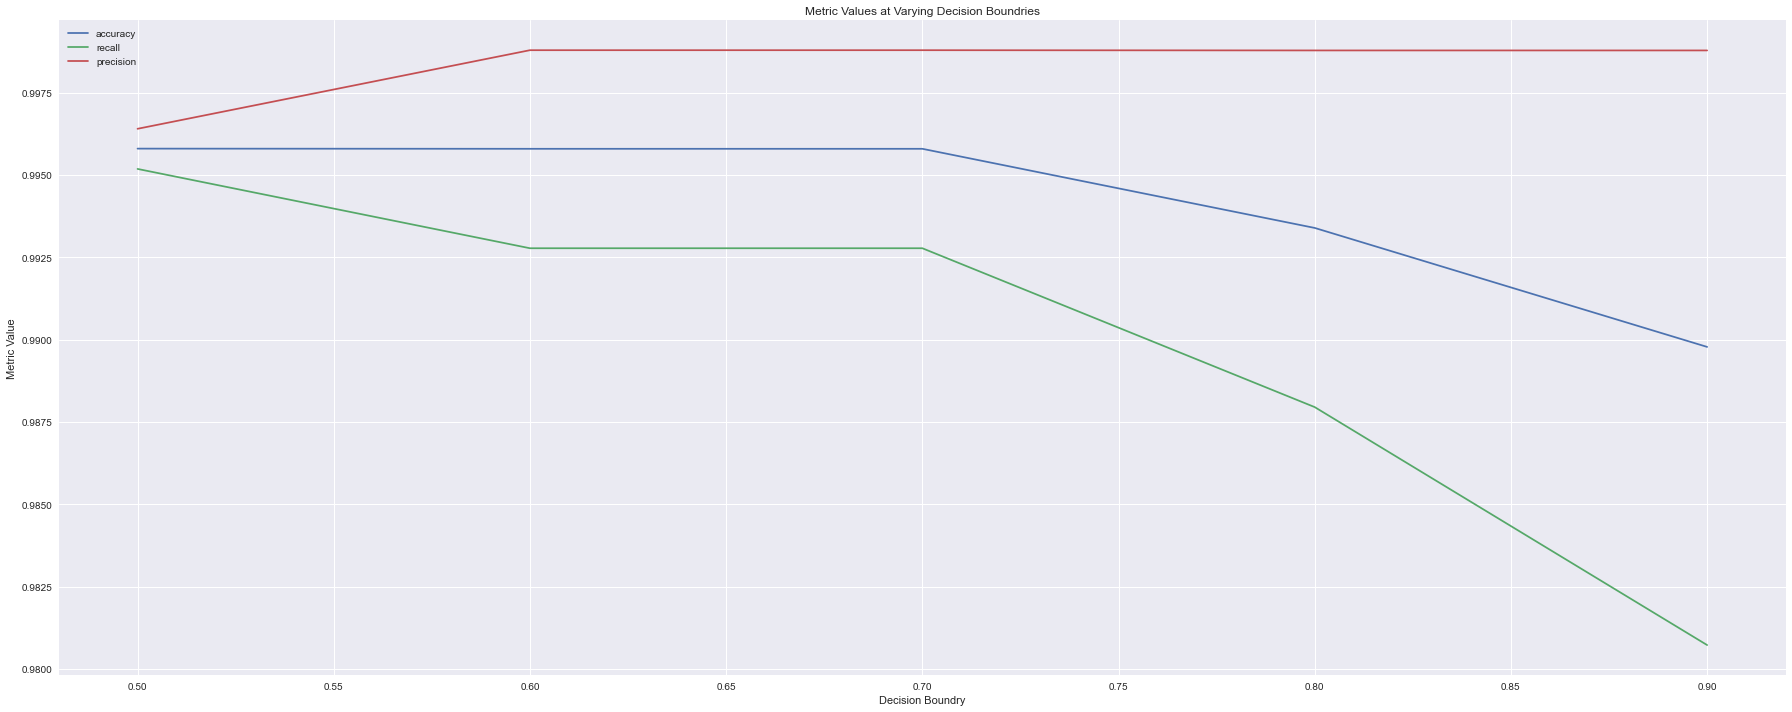

In [153]:
visualize_cv(thresh_search)

***Based on above diagram, it appears that a threshold value of 0.6 will maximize precision while having a no impact on accuracy (at least no impact on this cross validation experiment, may be some impact on a different dataset)***
***
## Re-evaluate Validtion set Performance with New Threshold of 0.6
- jobs must be at least 60% sure the product is satisfactory before labelling it satisfactory

In [149]:
predictions = (colorstorm.predict_proba(val["features"][:]) >= 0.6).astype("int")[:,1]

In [150]:
#Classification report
print(classification_report(val["labels"][:], predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       278
           1       0.99      1.00      1.00       277

    accuracy                           1.00       555
   macro avg       1.00      1.00      1.00       555
weighted avg       1.00      1.00      1.00       555



In [151]:
#Confusion matrix
print(confusion_matrix(val["labels"][:], predictions))

[[276   2]
 [  0 277]]


In [172]:
misclassifications = val_images["images"][:][val["labels"][:] != predictions].astype("uint8")

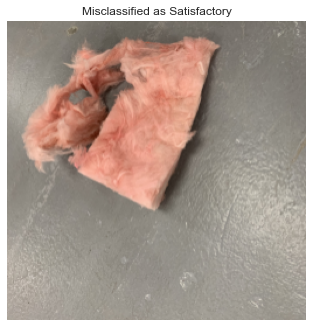

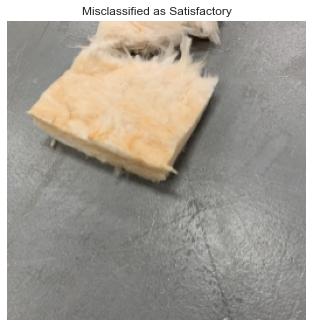

In [175]:
for i,img in enumerate(misclassifications):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(i)
    plt.imshow(img.astype("uint8"))
    plt.title("Misclassified as Satisfactory")
    plt.axis("off")

***These are the same images jobs missed with a decision boundry equal to 0.50***

The decision boundry was fine tuned with cross validation on the training data. Adjusting the decision boundry based solely on the validation data is risky considering it is one dataset and this adjustment could lead to overfitting. Additionally, each of the 5 folds in the cross validation experiment had ~332 instances while the validation set had 555 total instances. Each cross validation set is 60% of the size of the validation set. Thus, tuning the decision boundry via cross validation on the training sets and not adjusting the decsion boundry based on the validation set seems to be the technique which will allow for good generalization without overfitting.
***
## Final Notes:
- Decsion boundry of 0.6 (jobs is at least 60% certain the object in question is satisfactory before saying the object is satisfactory) appears to be optimal based on 5 fold cross validation
- Final last step of this project is to predict on the test set with this new threshold
    - Predict with 50/50 and 90/10 splits of satisfactory to defective images 